In [1]:
# https://towardsdatascience.com/calculating-string-similarity-in-python-276e18a7d33a
# https://pypi.org/project/fuzzywuzzy/
# https://www.adamsmith.haus/python/answers/how-to-find-a-similarity-metric-between-two-strings-in-python


from transformers import T5TokenizerFast, T5ForConditionalGeneration 
from transformers import Trainer

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import numpy as np
import torch
import torchvision
import Levenshtein
from fuzzywuzzy import fuzz
import time

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
def preprocess_combined_relations(row):
    row['combined relations'] = row['combined relations'].replace("'", '')
    row['combined relations'] = row['combined relations'].replace("[", '[ ')
    row['combined relations'] = row['combined relations'].replace("]", ' ]')
    row['combined relations'] = row['combined relations'].replace(",", ' ,')
    
    return row['combined relations']

In [3]:
def define_input_text(row):
    return '* ' + str(row["question"]) + ' *,* ' + str(row["entity label"]) + ' *,* ' + str(row["combined relations"]) + ' *'

In [4]:
def get_relation_label(rel_id):
    label = ''
    API_ENDPOINT = "https://www.wikidata.org/w/api.php"
    params = {
        'action': 'wbgetentities',
        'format': 'json',
        'languages': 'en',
        'props': 'labels',
        'ids': ''
    }
      
    params['ids'] = str(rel_id)

    try:
        response = requests.get(API_ENDPOINT, params = params).json()['entities']
        label = response[str(rel_id)]['labels']['en']['value']
    except:
        return label
    return label

In [5]:
from multiprocessing import Pool
from functools import partial
import inspect
import time
import os
import requests

def parallal_task(func, iterable, *params): 
    with open(f'./tmp_func.py', 'w') as file:
        file.write("import requests \n")
        file.write(inspect.getsource(func).replace(func.__name__, 'task'))

    from tmp_func import task
    pool = Pool(processes=15)
    res = pool.map(task, iterable)
    pool.close()
    
    os.remove('./tmp_func.py')
    return res

In [6]:
max_source_length = 1700
max_target_length = 128

In [7]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration 
from transformers import EarlyStoppingCallback

tokenizer = T5TokenizerFast.from_pretrained("t5-base")

In [8]:
model_path = "./Relation_linking_final_sub_obj/checkpoint-19000"
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

In [9]:
test_data = pd.read_csv('./3-Relation_Linking_Data/2-final_input/test_data.csv')
# test_data = test_data.sample(frac=1, random_state=1)
test_data

,question,entity label,relation labels,target relation id_x,target relation labels,qid,target relation id_y,relation_obj_labels,relation_obj_ids,combined relations
0,Which genre of album is harder.....faster?,NaN,"record label , instance of , follows , fol...",P136,genre,Q5487302,P136,"follows, followed by, part of","P155, P156, P361","['record label', 'follows', 'instance of', 'fo..."
1,what city was alex golfis born in,alex golfis,"instance of , sex or gender , occupation , ...",P19,place of birth,Q16330302,P19,cast member,P161,"['instance of', 'cast member', 'sex or gender'..."
2,what film is by the writer phil hay?,phil hay,"instance of , sex or gender , country of ci...",P58,screenwriter,Q16225521,P58,"father, spouse, screenwriter, producer","P22, P26, P58, P162","['instance of', 'father', 'sex or gender', 'sp..."
3,Where did roger marquis die,roger marquis,"date of birth , date of death , instance of...",P20,place of death,Q7358590,P20,different from,P1889,"['date of birth', 'different from', 'date of d..."
4,what was the cause of death of yves klein,yves klein,"sex or gender , place of birth , VIAF ID , ...",P509,cause of death,Q154335,P509,"spouse, founded by, child, father, influenced ...","P26, P112, P40, P22, P737, P61, P86, P710, P50...","['sex or gender', 'spouse', 'place of birth', ..."
...,...,...,...,...,...,...,...,...,...,...
9915,who was the creator of the fictional character...,doctor faustus,"from narrative universe , Freebase ID , cou...",P170,creator,Q1447249,P170,enemy of,P7047,"['from narrative universe', 'enemy of', 'Freeb..."
9916,what's a college sporting event that took plac...,oklahoma city,"topics main category , Dewey Decimal Classif...",P276,location,Q34863,P276,"item for this sense, place of birth, place of ...","P5137, P19, P20, P131, P190, P36, P159, P937, ...","['topics main category', 'item for this sense'..."
9917,what celestial object is 2974 holden,2974 holden,"named after , discoverer or inventor , foll...",P31,instance of,Q582715,P31,"follows, followed by","P155, P156","['named after', 'follows', 'discoverer or inve..."
9918,what is the film genre for snow falling on ced...,snow falling on cedars,"instance of , IMDb ID , director , cast me...",P136,genre,Q582147,P136,derivative work,P4969,"['instance of', 'derivative work', 'IMDb ID', ..."


In [10]:
test_data['combined relations'] = test_data.apply(preprocess_combined_relations, axis =1)
test_data

,question,entity label,relation labels,target relation id_x,target relation labels,qid,target relation id_y,relation_obj_labels,relation_obj_ids,combined relations
0,Which genre of album is harder.....faster?,NaN,"record label , instance of , follows , fol...",P136,genre,Q5487302,P136,"follows, followed by, part of","P155, P156, P361","[ record label , follows , instance of , follo..."
1,what city was alex golfis born in,alex golfis,"instance of , sex or gender , occupation , ...",P19,place of birth,Q16330302,P19,cast member,P161,"[ instance of , cast member , sex or gender , ..."
2,what film is by the writer phil hay?,phil hay,"instance of , sex or gender , country of ci...",P58,screenwriter,Q16225521,P58,"father, spouse, screenwriter, producer","P22, P26, P58, P162","[ instance of , father , sex or gender , spous..."
3,Where did roger marquis die,roger marquis,"date of birth , date of death , instance of...",P20,place of death,Q7358590,P20,different from,P1889,"[ date of birth , different from , date of dea..."
4,what was the cause of death of yves klein,yves klein,"sex or gender , place of birth , VIAF ID , ...",P509,cause of death,Q154335,P509,"spouse, founded by, child, father, influenced ...","P26, P112, P40, P22, P737, P61, P86, P710, P50...","[ sex or gender , spouse , place of birth , fo..."
...,...,...,...,...,...,...,...,...,...,...
9915,who was the creator of the fictional character...,doctor faustus,"from narrative universe , Freebase ID , cou...",P170,creator,Q1447249,P170,enemy of,P7047,"[ from narrative universe , enemy of , Freebas..."
9916,what's a college sporting event that took plac...,oklahoma city,"topics main category , Dewey Decimal Classif...",P276,location,Q34863,P276,"item for this sense, place of birth, place of ...","P5137, P19, P20, P131, P190, P36, P159, P937, ...","[ topics main category , item for this sense ,..."
9917,what celestial object is 2974 holden,2974 holden,"named after , discoverer or inventor , foll...",P31,instance of,Q582715,P31,"follows, followed by","P155, P156","[ named after , follows , discoverer or invent..."
9918,what is the film genre for snow falling on ced...,snow falling on cedars,"instance of , IMDb ID , director , cast me...",P136,genre,Q582147,P136,derivative work,P4969,"[ instance of , derivative work , IMDb ID , di..."


In [11]:
test_data['input_text'] = test_data.apply(define_input_text, axis=1)
# training_data.head()

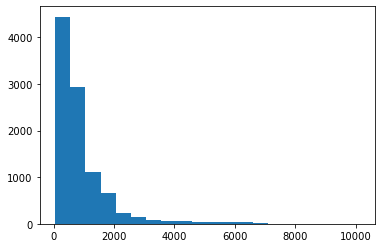

In [12]:
import matplotlib.pyplot as plt
plt.hist(test_data['input_text'].str.len(), bins = 20)
plt.show()

In [13]:
input_text = list(test_data['input_text'])
input_text[0]

'* Which genre of album is harder.....faster? *,* nan *,* [ record label , follows , instance of , followed by , follows , part of , followed by , performer , MusicBrainz release group ID , Discogs master ID , Freebase ID , AllMusic album ID , publication date , producer , genre , Amazon Standard Identification Number , Spotify album ID , coordinates of the point of view , distribution format ] *'

In [14]:
target_text = list(test_data['target relation labels'].astype(str))
target_text[0]

'genre'

In [15]:
tokens = []
for text in input_text:
    tokens.append(tokenizer('relation_linking: ' + text, return_tensors="pt", padding=True, truncation=True, max_length=max_source_length).input_ids)

In [16]:
start = time.time()
counter = 0
simple_predictions = []
for token in tokens:
    if counter%100 == 0:
        print(counter)
    counter += 1
    prediction = model.generate(token.to(device))
    simple_predictions.append(prediction)
    
print(time.time() - start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
795.9633829593658


In [17]:
final_ouput_2 = []
for result in simple_predictions:
    final_ouput_2.append(tokenizer.decode(result[0], skip_special_tokens=True))

In [18]:
final_ouput_2[:50]

['genre',
 'place of birth',
 'screenwriter',
 'place of death',
 'cause of death',
 'place of birth',
 'genre',
 'ethnic group',
 'position played on team / speciality',
 'sex or gender',
 'position played on team / speciality',
 'cause of death',
 'genre',
 'place of death',
 'original language of film or TV show',
 'influenced by',
 'place of birth',
 'conflict',
 'record label',
 'architectural style',
 'publisher',
 'genre',
 'genre',
 'place of birth',
 'occupation',
 'position played on team / speciality',
 'place of death',
 'founded by',
 'genre',
 'director',
 'place of birth',
 'location',
 'composer',
 'place of birth',
 'located in time zone',
 'genre',
 'place of birth',
 'place of birth',
 'genre',
 'architectural style',
 'place of birth',
 'country of citizenship',
 'genre',
 'genre',
 'genre',
 'performer',
 'genre',
 'country of origin',
 'architect',
 'performer']

In [19]:
counter = 0
for i in range(len(final_ouput_2)):
    if final_ouput_2[i] == target_text[i]:
        counter += 1
counter*100/len(final_ouput_2)

97.8024193548387

In [20]:
simple_predictions

[tensor([[   0, 5349,    1]], device='cuda:0'),
 tensor([[   0,  286,   13, 3879,    1]], device='cuda:0'),
 tensor([[    0,  1641, 12756,     1]], device='cuda:0'),
 tensor([[   0,  286,   13, 1687,    1]], device='cuda:0'),
 tensor([[   0, 1137,   13, 1687,    1]], device='cuda:0'),
 tensor([[   0,  286,   13, 3879,    1]], device='cuda:0'),
 tensor([[   0, 5349,    1]], device='cuda:0'),
 tensor([[    0, 11655,   563,     1]], device='cuda:0'),
 tensor([[   0, 1102, 1944,   30,  372,    3,   87,  534,  485,    1]],
        device='cuda:0'),
 tensor([[   0,    3,    7,  994,   42, 7285,    1]], device='cuda:0'),
 tensor([[   0, 1102, 1944,   30,  372,    3,   87,  534,  485,    1]],
        device='cuda:0'),
 tensor([[   0, 1137,   13, 1687,    1]], device='cuda:0'),
 tensor([[   0, 5349,    1]], device='cuda:0'),
 tensor([[   0,  286,   13, 1687,    1]], device='cuda:0'),
 tensor([[   0,  926, 1612,   13,  814,   42, 1424,  504,    1]],
        device='cuda:0'),
 tensor([[    0,    